# Colab setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 扫描到相应的路径
import sys
sys.path.append('/content/drive/MyDrive/market_simulator')
sys.path.append('/content/drive/MyDrive/market_simulator/src')
sys.path.append('/content/drive/MyDrive/market_simulator/src/utils')

# Import

In [3]:
pip install esig

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 28.6 MB/s eta 0:00:00


In [ ]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import datetime

import base
import cvae
import importlib
importlib.reload(cvae)

from esig import tosig as esigtosig
from esig.tosig import sigkeys
from esig.tosig import stream2logsig

# import self-defind .py file under src
from utils.leadlag import leadlag
from utils import tosig
import logsig_inversion
import market_generator
import process_discriminator



# CVAE

## Create the data

In [ ]:
data, conditions = make_circles(n_samples=10000, noise=0.05, factor=0.5)

# We normalise the data to [0, 1]^2
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

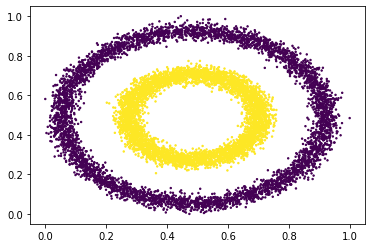

In [ ]:
# Plot dataset
plt.scatter(*data.T, c=conditions, s=2)
plt.show()

## Train the CVAE

In [ ]:
generator = cvae.CVAE(n_latent=4, alpha=0.02)
generator.train(data, data_cond=conditions.reshape(-1, 1),
                n_epochs=10000)

/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:24: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  x = tf.layers.flatten(x)
/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(x, units=self.n_hidden, activation=self.lrelu)
/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  mn = tf.layers.dense(x, units=self.n_latent, activation=self.lrelu)
/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

## Generate samples

In [ ]:
outer_circle_generated = generator.generate((0,), n_samples=1000)
inner_circle_generated = generator.generate((1,), n_samples=1000)

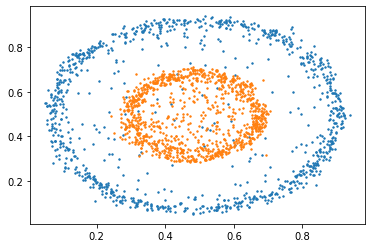

In [ ]:
plt.scatter(*outer_circle_generated.T, s=2)
plt.scatter(*inner_circle_generated.T, s=2)
plt.show()

# logsig_inversion

## Generate path

In [ ]:
# Pip size
pip = 0.01

# Number of pips for search space
n_pips = 10

# Number of points
n_points = 21

path = np.r_[0., pip * np.random.randint(-n_pips, n_pips, size=n_points - 1).cumsum()]

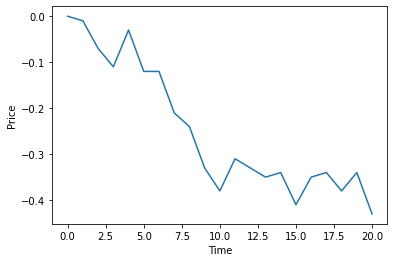

In [ ]:
plt.plot(path)
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [ ]:
# Compute log-signature

order = 4
leadlag_path = leadlag(path)
logsig = esigtosig.stream2logsig(leadlag_path, order)

print(f"Log-signature: {logsig}")

Log-signature: [-4.30000000e-01 -4.30000000e-01 -3.25500000e-02  5.71416667e-04
  1.01058333e-03 -4.34350000e-05 -8.02987500e-05 -5.32150000e-05]


## Invert log-signature

In [ ]:
n_iterations = 100
n_organisms = 1000
recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

  0%|          | 0/100 [00:00<?, ?it/s]

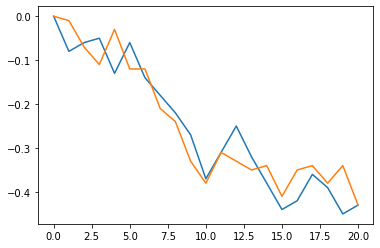

Real log-signature: [-4.30000000e-01 -4.30000000e-01 -3.25500000e-02  5.71416667e-04
  1.01058333e-03 -4.34350000e-05 -8.02987500e-05 -5.32150000e-05]
Recovered log-signature: [-4.30000000e-01 -4.30000000e-01 -3.42500000e-02  5.66416667e-04
  1.03158333e-03 -4.43000000e-05 -7.28445833e-05 -4.36000000e-05]


In [ ]:
plt.plot(recovered_path)
plt.plot(path)
plt.show()
print(f"Real log-signature: {logsig}")
print(f"Recovered log-signature: {esigtosig.stream2logsig(leadlag(recovered_path), order)}")

# market_generator

In [ ]:
# Signature order
order = 4

## Load monthly paths

In [ ]:
# ^GSPC is S&P 500.
ticker = "^GSPC"
MG = market_generator.MarketGenerator(ticker, start=datetime.date(2000, 1, 1),
                                      freq="W", sig_order=order)

Computing log-signatures:   0%|          | 0/1037 [00:00<?, ?it/s]

## Plot paths

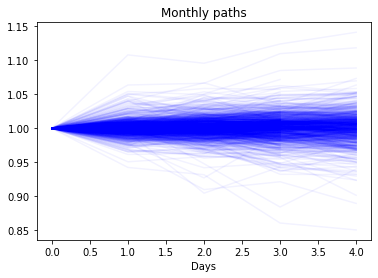

In [ ]:
for path in MG.windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [ ]:
MG.train(n_epochs=10000)

/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:24: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  x = tf.layers.flatten(x)
/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(x, units=self.n_hidden, activation=self.lrelu)
/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  mn = tf.layers.dense(x, units=self.n_latent, activation=self.lrelu)
/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

## Generate

In [ ]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))
#generated = MG.generate(MG.conditions[150][2] * 0.5, n_samples=len(MG.logsigs))

generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.orig_logsig)])

100%|██████████| 1037/1037 [00:32<00:00, 32.24it/s]


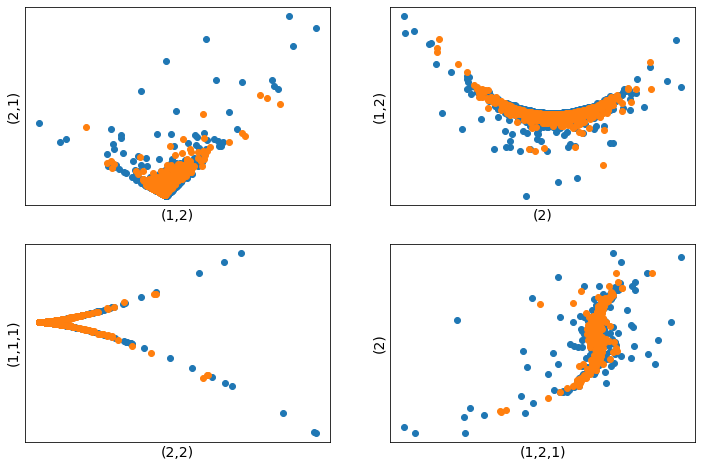

In [ ]:
keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

In [ ]:
normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])
sigs1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(normalised_generated)])
sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

100%|██████████| 1036/1036 [00:30<00:00, 34.24it/s]


Computing signatures of population 1:   0%|          | 0/1036 [00:00<?, ?it/s]

Computing signatures of population 2:   0%|          | 0/1036 [00:00<?, ?it/s]

Are the generated and real distributions DIFFERENT? False


## Invert log-signature

In [ ]:
logsig = MG.generate(MG.conditions[0])

In [ ]:
pip = 0.01
n_pips = 50 * 100 # 50$
n_points = 21

n_iterations = 100
n_organisms = 100

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

  0%|          | 0/100 [00:00<?, ?it/s]

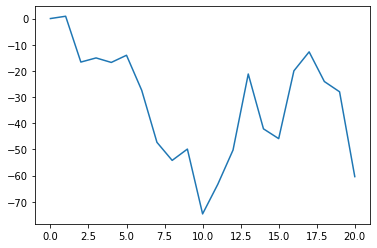

Target log-signature: [-56.76286315917969, -60.83625793457031, -2146.40673828125, 19733.974609375, 32295.14453125, 10733.1904296875, -131086.25, -187643.359375]
Recovered log-signature: [-60.370000000000005, -60.370000000000005, -2541.82755, 19661.640390916666, 24639.663925083336, 10568.08463430003, 56058.525944346155, -86964.21255086974]


In [ ]:
plt.plot(recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [ ]:
paths = []
for condition in MG.conditions:
    logsig = MG.generate(condition)
    recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points, pip, n_pips)
    
    paths.append(recovered_path)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

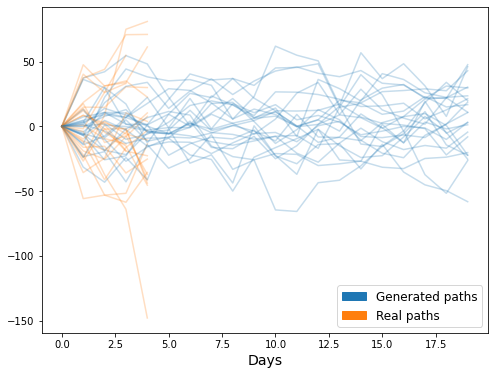

In [ ]:
plt.figure(figsize=(8, 6))
for path1, path2 in zip(paths, MG.windows):
    returns = path2[::2, 1][:20] - path2[0, 1]
    plt.plot(returns, "C1", alpha=0.25)

    plt.plot(path1[:20], "C0", alpha=0.25)
    
    
blue_patch = mpatches.Patch(color='C0', label='Generated paths')
red_patch = mpatches.Patch(color='C1', label='Real paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
plt.xlabel("Days", fontsize=14) 
plt.show()

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


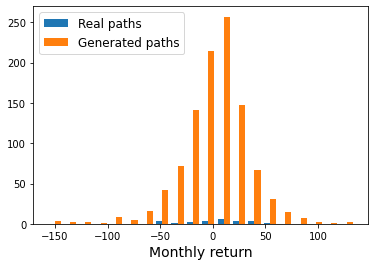

In [ ]:
returns1 = [path[-1] - path[0] for path in paths]
returns2 = [path[-1, 1] - path[0, 0] for path in MG.windows]

_ = plt.hist([returns1, returns2], bins=20, label=["Real paths", "Generated paths"])
plt.xlabel("Monthly return", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [ ]:
def concatenate(condition, periods):
    joined_path = None

    for _ in range(periods):
        generated = MG.generate(condition)
        path, loss = logsig_inversion.train(generated, order, n_iterations, n_organisms, n_points,
                                            pip, n_pips)

        condition = tosig.stream2logsig(market_generator.leadlag(recovered_path), order)
        condition = MG.scaler.transform([condition])[0]

        if joined_path is None:
            joined_path = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]
            
    return joined_path

In [ ]:
idx = 220

condition = MG.conditions[idx]

paths = [concatenate(condition, 12) for _ in range(10)]

plt.plot(np.transpose(paths))
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

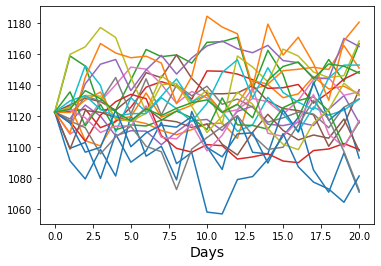

In [ ]:
plt.plot(MG.windows[idx + 1][0, 0] + np.transpose(paths))
plt.xlabel("Days", fontsize=14) 
plt.show()

# market_generator_returns

## Load monthly paths

In [ ]:
importlib.reload(market_generator)

<module 'market_generator' from '/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/market_generator.py'>

In [ ]:
# ^GSPC is S&P 500.
ticker = "^GSPC"
MG = market_generator.MarketGenerator(ticker, start=datetime.date(2000, 1, 1),
                                      freq="W", sig_order=None)

/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/market_generator.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.orig_logsig = np.array([np.diff(np.log(path[::2, 1])) for path in self.windows])


## Plot paths

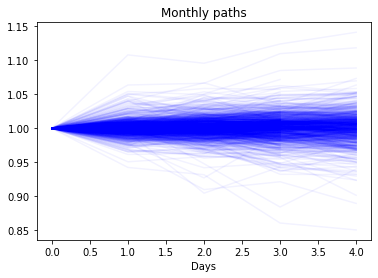

In [ ]:
for path in MG.windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [ ]:
MG.train(n_epochs=10000)

/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:24: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  x = tf.layers.flatten(x)
/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(x, units=self.n_hidden, activation=self.lrelu)
/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  mn = tf.layers.dense(x, units=self.n_latent, activation=self.lrelu)
/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

## Generate

In [ ]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))

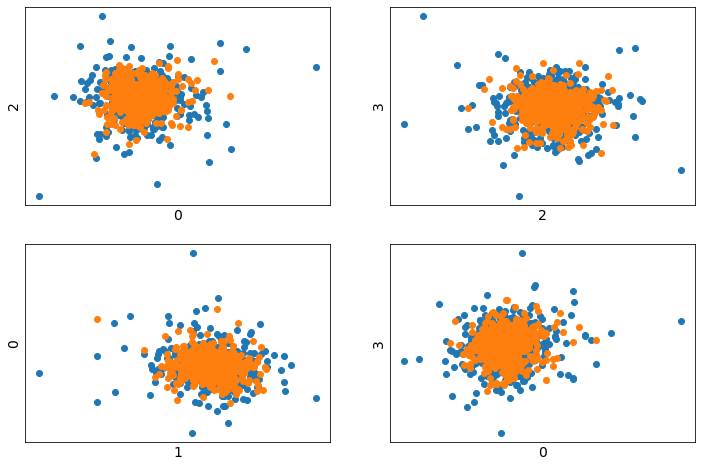

In [ ]:
PROJECTIONS = [(0, 2), (2, 3), (1, 0), (0, 3)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(MG.orig_logsig[:, projection[0]], MG.orig_logsig[:, projection[1]],
                label="Real data")
    plt.scatter(generated[:, projection[0]], generated[:, projection[1]],
               label="Generated")
    plt.xlabel(projection[0], fontsize=14)
    plt.ylabel(projection[1], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

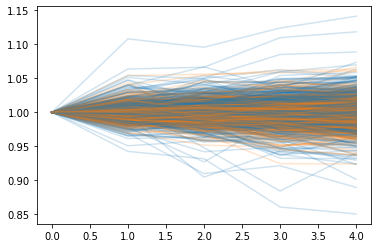

In [ ]:
paths_generated = np.exp(MG.orig_logsig.cumsum(axis=1))
paths_orig = np.exp(generated.cumsum(axis=1))
for p1, p2 in zip(paths_generated, paths_orig):
    plt.plot(np.r_[1., p1], "Cc0", alpha=0.2)
    plt.plot(np.r_[1., p2], "C1", alpha=0.2)
    
    
plt.show()

In [ ]:
pip install iisignature

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.9 MB/s 
  Created wheel for iisignature: filename=iisignature-0.24-cp38-cp38-linux_x86_64.whl size=2527073 sha256=5a29aad38d967066a1bfe0e10b30613c2506b6cd9af7c4d2a19eba7d39ff226d
  Stored in directory: /root/.cache/pip/wheels/48/27/44/79062cc4e18eb42f9ae992a83db3ecfd99d2dff35446daa3f8
Successfully built iisignature


In [ ]:
import iisignature

order = 4
sigs1 = np.array([np.r_[1., iisignature.sig(leadlag(p), order)] for p in tqdm(paths_generated[:-1])])
sigs2 = np.array([np.r_[1., iisignature.sig(leadlag(p), order)] for p in tqdm(paths_orig)])

100%|██████████| 856/856 [00:00<00:00, 14131.13it/s]


In [ ]:
importlib.reload(process_discriminator)

<module 'process_discriminator' from '/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/process_discriminator.py'>

In [ ]:
res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.9999)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

Computing signatures of population 1:   0%|          | 0/856 [00:00<?, ?it/s]

Computing signatures of population 2:   0%|          | 0/856 [00:00<?, ?it/s]

Are the generated and real distributions DIFFERENT? False


# market_generator_rough_bergomi

In [ ]:
# Signature order
order = 4

## Load monthly paths

In [ ]:
# ^GSPC is S&P 500.
ticker = "^GSPC"
params = {
            "M": 1000,
            "H": 0.14,
            "rho": -0.85,
            "xi0": 0.1,
            "nu": 1.5,
            "S0": 1.
          }
MG = market_generator.MarketGenerator(ticker, start=datetime.date(2000, 1, 1),
                                      freq="M", sig_order=order, rough_bergomi=params)

Computing log-signatures:   0%|          | 0/1000 [00:00<?, ?it/s]

## Plot paths

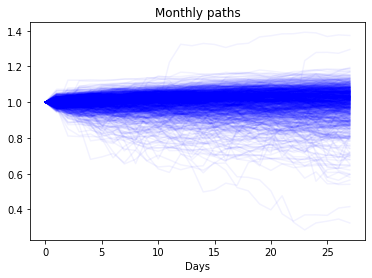

In [ ]:
for path in MG.windows:
    returns = path[::2, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [ ]:
MG.train(n_epochs=10000)

/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:24: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  x = tf.layers.flatten(x)
/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(x, units=self.n_hidden, activation=self.lrelu)
/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  mn = tf.layers.dense(x, units=self.n_latent, activation=self.lrelu)
/content/drive/MyDrive/market_simulator-master/market_simulator-master/src/cvae.py:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

## Generate

In [ ]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))
#generated = MG.generate(MG.conditions[150][2] * 0.5, n_samples=len(MG.logsigs))

generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.orig_logsig)])

100%|██████████| 1000/1000 [00:21<00:00, 46.48it/s]


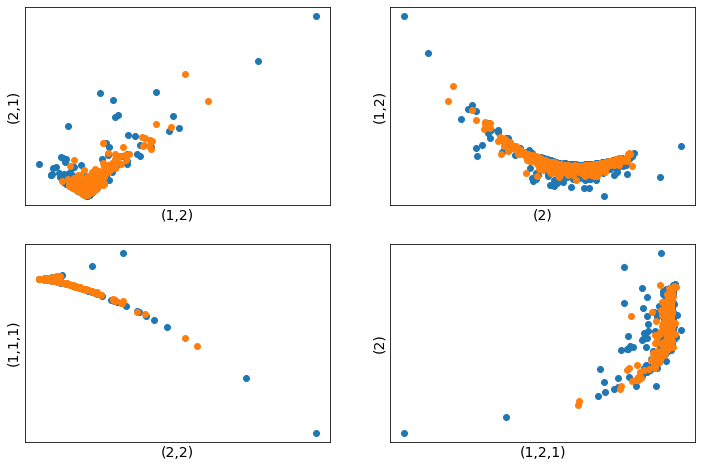

In [ ]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

In [ ]:
normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])
sigs1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(normalised_generated)])
MG._load_rough_bergomi(params)
sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

100%|██████████| 999/999 [00:21<00:00, 46.35it/s]


Computing signatures of population 1:   0%|          | 0/999 [00:00<?, ?it/s]

Computing signatures of population 2:   0%|          | 0/999 [00:00<?, ?it/s]

Are the generated and real distributions DIFFERENT? False


## Invert log-signature

In [ ]:
logsig = MG.generate(MG.conditions[0])

In [ ]:
pip = 0.001
n_pips = 5 * 10
n_points = 21

n_iterations = 100
n_organisms = 100

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

  0%|          | 0/100 [00:00<?, ?it/s]

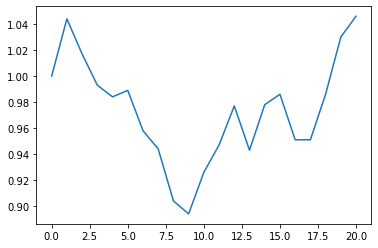

Target log-signature: [0.046604570001363754, 0.045600540935993195, -0.007388979662209749, 0.00040758514660410583, 0.00033264074590988457, -1.749090733937919e-05, -2.736780879786238e-05, -1.7205409676535055e-05]
Recovered log-signature: [0.046000000000000006, 0.046000000000000006, -0.007828, 0.0003909223333333333, 0.0003716006666666666, -1.4156595999999998e-05, -2.7581903666666665e-05, -1.4252784000000001e-05]


In [ ]:
plt.plot(1 + recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [ ]:
paths = []
for condition in MG.conditions:
    logsig = MG.generate(condition)
    recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                                  pip, n_pips)
    
    paths.append(recovered_path)

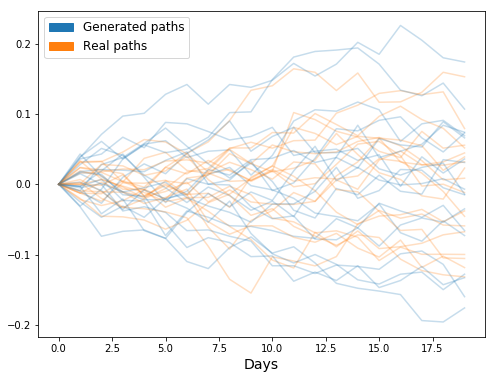

In [ ]:
plt.figure(figsize=(8, 6))
for path1, path2 in zip(paths, MG.windows):
    returns = path2[::2, 1][:20] - path2[0, 1]
    plt.plot(returns, "C1", alpha=0.25)

    plt.plot(path1[:20], "C0", alpha=0.25)
    
    
blue_patch = mpatches.Patch(color='C0', label='Generated paths')
red_patch = mpatches.Patch(color='C1', label='Real paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
plt.xlabel("Days", fontsize=14) 
plt.show()

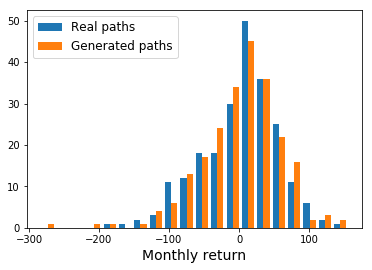

In [ ]:
returns1 = [path[-1] - path[0] for path in paths]
returns2 = [path[-1, 1] - path[0, 0] for path in MG.windows]

_ = plt.hist([returns1, returns2], bins=20, label=["Real paths", "Generated paths"])
plt.xlabel("Monthly return", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [ ]:
def concatenate(condition, periods):
    joined_path = None

    for _ in range(periods):
        generated = MG.generate(condition)
        path, loss = logsig_inversion.train(generated, order, n_iterations, n_organisms, n_points,
                                            pip, n_pips)

        condition = tosig.stream2logsig(market_generator.leadlag(recovered_path), order)
        condition = MG.scaler.transform([condition])[0]

        if joined_path is None:
            joined_pacth = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]
            
    return joined_path

In [ ]:
idx = 220

condition = MG.conditions[idx]

paths = [concatenate(condition, 12) for _ in range(10)]

plt.plot(np.transpose(paths))
plt.show()

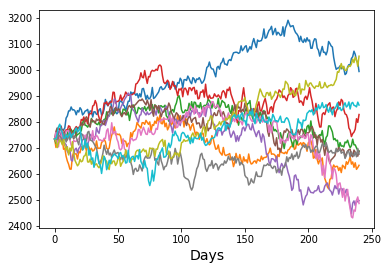

In [ ]:
plt.plot(MG.windows[idx + 1][0, 0] + np.transpose(paths))
plt.xlabel("Days", fontsize=14) 
plt.show()

# process_discriminator

## Generate paths

 We will generate Geometric Brownian Motions. We define three sets, `set1`, `set2` and  `set3`. `set1` and `set3` come from the same distribution and `set2` is not.

In [ ]:
def generate(mu, sigma, n_points=100):
    """Generate GBM."""
    
    dt = 1 / np.sqrt(n_points)
    
    timeline = np.linspace(0, 1, n_points)
    bm = dt * np.r_[0., np.random.randn(n_points - 1).cumsum()]
    path = np.exp((mu - sigma ** 2 / 2.) * timeline + sigma * bm)
    
    return np.c_[timeline, path]    

100%|██████████| 5000/5000 [00:00<00:00, 8519.57it/s]


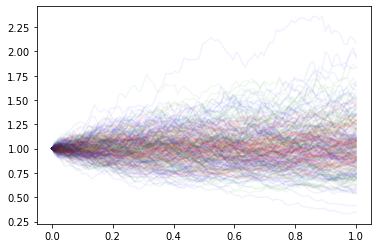

In [ ]:
set1 = [generate(mu=0.02, sigma=0.3) for _ in tqdm(range(5000))]
set2 = [generate(mu=0.02, sigma=0.2) for _ in tqdm(range(5000))]
set3 = [generate(mu=0.02, sigma=0.3) for _ in tqdm(range(5000))]

for path1, path2, path3 in zip(set1[:100], set2[:100], set3[:100]):
    plt.plot(*path1.T, "b", alpha=0.05)
    plt.plot(*path2.T, "r", alpha=0.05)
    plt.plot(*path3.T, "g", alpha=0.05)

## Apply test

We will now apply the statistical test. We fix the confidence level to 99%.

In [ ]:
result = process_discriminator.test(set1, set2, order=3, confidence_level=0.99)
print("Do set1 and set2 come from DIFFERENT distributions? {}".format(result))

Computing signatures of population 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing signatures of population 2:   0%|          | 0/5000 [00:00<?, ?it/s]

Do set1 and set2 come from DIFFERENT distributions? False


In [ ]:
result = process_discriminator.test(set1, set3, order=3, confidence_level=0.99)
print("Do set1 and set3 come from DIFFERENT distributions? {}".format(result))

Computing signatures of population 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing signatures of population 2:   0%|          | 0/5000 [00:00<?, ?it/s]

Do set1 and set3 come from DIFFERENT distributions? False
